In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import skimage
import os
import pickle
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

nAnchors = 24
batchSize = 16
numEpochs = 200
device = "cuda"
rng = np.random.default_rng(12345)

In [5]:
class AnchorDataSet(torch.utils.data.Dataset):
    def __init__(self, file, transform = None, target_transform=None):
        super(AnchorDataSet, self).__init__()
        self.df = pd.read_pickle(file).reset_index()
        self.transform = transform
        self.target_transform=target_transform
     
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):
        
        feats = self.df.loc[idx, "Features"].astype(np.double)
        anchorDists = self.df.loc[idx, "AnchorDists"].astype(np.double)
        
        dofs = np.array([self.df.loc[idx,"Z"],self.df.loc[idx,"W"],self.df.loc[idx,"P"],self.df.loc[idx,"Q"],self.df.loc[idx,"R"]]).astype(np.double)
        
        xy = np.array([self.df.loc[idx,"X"], self.df.loc[idx,"Y"]]).astype(np.double)
        imageFile = self.df.loc[idx, "ImageFile"]

        return {"Features": feats,
                "anchorDists": anchorDists,
                "dofs": dofs,
                "xy": xy,
                "ImageFile": imageFile}


class anchorNet(nn.Module):
    def __init__(self, nAnchors):
        super(anchorNet, self).__init__()
        self.classifier = nn.Linear(2208, nAnchors)
        self.regressor = nn.Linear(2208, 2*nAnchors)
        self.dof_regressor = nn.Linear(2208, 5)
        self.softmax = nn.Softmax(dim=-1)
        self.double()
    
    def forward(self, feats):

        classify = self.softmax(self.classifier(feats)) # TODO: ReLU useful?
        regress = self.regressor(feats)
        dof_regress = self.dof_regressor(feats)

        return classify, regress, dof_regress

class deepAnchorNet(nn.Module):
    def __init__(self, nAnchors, dropout=0.3):
        super(deepAnchorNet, self).__init__()
        self.classifier = nn.ModuleList([nn.Linear(2208, 1104), nn.ReLU(), nn.Dropout(p=dropout), nn.Linear(1104,700), nn.ReLU(), nn.Linear(700,350), nn.ReLU(), nn.Dropout(p=dropout), nn.Linear(350, nAnchors)])
        self.regressor = nn.ModuleList([nn.Linear(2208, 1104), nn.ReLU(), nn.Dropout(p=dropout), nn.Linear(1104,700), nn.ReLU(), nn.Linear(700,350), nn.ReLU(), nn.Dropout(p=dropout), nn.Linear(350, 2*nAnchors)])
        self.dof_regressor = nn.Linear(2208, 5)
        self.softmax = nn.Softmax(dim=-1)
        self.double()
    
    def forward(self, feats):
        c = nn.functional.relu(feats)
        regress = nn.functional.relu(feats)
        
        for layer in self.classifier:
            c = layer(c)

        for layer in self.regressor:
            regress = layer(regress)

        classify = self.softmax(c) # TODO: ReLU useful?

        dof_regress = self.dof_regressor(nn.functional.relu(feats))

        return classify, regress, dof_regress

def custom_loss(classify, regress, dof_regress, anchorDistsGt, dofGt, dofLoss, crossEntropy, factors = [2.4,0,0.5]):
    # TODO: Possible Flaw (or the reason why this works?):
    # The net tries to learn realtive position to each anchorpoint
    # independently, so we have a large amount of degrees of freedom, even though relative
    # position to anchor points should have 2 DOF. Maybe try using more anchorpoints to
    # proof this point.

    """
    classify: output of anchor classifier
    regress: output of regressor
    dof_regress: output of dof_regressor
    anchorDistsGt: true distance to all anchor poitns
    dofGt: true remaining 4 DOF
    dofLoss: loss function used for dof_regressor
    factors: list of hyperparameters for weighting of different loss terms
    """

    dist = (regress.reshape(-1, nAnchors, 2) - anchorDistsGt)

    # TODO: Use softmax on gt-dof and dof for normalization
    lossXY = torch.sum(torch.linalg.norm(dist, axis = -1) * classify)
    
    nearest = torch.argmin(torch.linalg.norm(anchorDistsGt, axis=-1), axis=-1)

    if rng.permutation(500)[0] == 0:
        print("Cross Entropy Loss of classifier: ", crossEntropy(classify, nearest).cpu().detach().data.item())

    return factors[0] * lossXY + factors[1]*crossEntropy(classify, nearest) + factors[2] * dofLoss(dof_regress, dofGt), crossEntropy(classify, nearest).cpu().detach().data.item()


In [16]:
numEpochs = 200
hyperparameters = {"setting1": [24, 16, 0.0003, 0.5],
                    "setting2": [24, 8, 0.0003, 0.2],
                    "setting3": [10, 16, 0.0003, 0.2],
                    "setting4": [33, 16, 0.0003, 0.2],
                    "setting5": [24, 16, 0.001, 0.2],
                    "setting6": [24, 16, 0.0001, 0.2],
                    "setting7": [24, 16, 0.0003, 0.7],
                    "setting8": [24, 16, 0.0003, 0.1],
                    "setting9": [10, 4, 0.0003, 0.2],
                    "setting10": [10, 16, 0.0001, 0.2],
                    "setting11": [10, 4, 0.0001, 0.2],
                    "setting12": [16, 4, 0.0001, 0.2],
                    "setting13": [24, 4, 0.0001, 0.2],
                    "setting14": [16, 1, 0.0001, 0.2],
                    "setting15": [10, 4, 0.0001, 0.2],
                    }

for hp in list(hyperparameters.keys()):

    nAnchors = hyperparameters[hp][0]
    batchSize = hyperparameters[hp][1]
    learningRate = hyperparameters[hp][2]
    gamma = hyperparameters[hp][3]

    trainDataset = AnchorDataSet(file= f"./ShopFacade/traindata_with_features_and_anchors{nAnchors}.pkl")
    trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=False, num_workers=0)

    testDataset = AnchorDataSet(file= f"./ShopFacade/testdata_with_features_and_anchors{nAnchors}.pkl")
    testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, shuffle=False, num_workers=0)

    myNet = anchorNet(nAnchors=nAnchors).to(device)
    dofLoss = nn.MSELoss().to(device)
    crossEntropy = nn.CrossEntropyLoss().to(device)

    optimizer = torch.optim.Adam(myNet.parameters(), lr=learningRate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=gamma)

    myAnchors = torch.from_numpy(np.loadtxt(f"./ShopFacade/anchors{nAnchors}.txt")).to(device)

    epochs = []
    testXY = []
    testZ = []
    testRot = []
    trainLoss = np.zeros(numEpochs)
    trainCELoss = np.zeros(numEpochs)

    for epoch in range(numEpochs):
        epochLoss = 0
        trainDists = []
        zTrain = []
        dofTrain = []

        for i, data in enumerate(trainDataloader):

            myNet.train()

            optimizer.zero_grad()
            
            myFeats = data["Features"]
            myFeats = myFeats.to(device)

            myAnchorDistsGt = data["anchorDists"]
            myAnchorDistsGt = myAnchorDistsGt.to(device)

            myDofGt = data["dofs"]
            myDofGt = myDofGt.to(device)

            myXyGt = data["xy"]
            myXyGt = myXyGt.to(device)

            classify, regress, dof_regress = myNet.forward(myFeats)
            loss, cEntLoss = custom_loss(classify, regress, dof_regress, anchorDistsGt=myAnchorDistsGt, dofGt=myDofGt, dofLoss=dofLoss, crossEntropy=crossEntropy, factors=[1,0,1])
            loss.backward()
            
            optimizer.step()
            dLoss = loss.data.item()
            epochLoss += dLoss
            
            with torch.no_grad():
                bestAnchor = torch.argmax(classify, axis=1).to(device)

                dist = 0
                dofDist = 0

                for j in range(bestAnchor.size()[0]):
                    dist += torch.linalg.norm(torch.abs((myAnchors[bestAnchor[j], :] - regress.reshape(-1,nAnchors,2)[j,bestAnchor[j], :]) - (myXyGt)[j]))
                    dofDist += np.mean(Rotation.from_quat(dof_regress[j,1:].cpu().detach().numpy()).as_euler("xyz", degrees=True) - Rotation.from_quat(myDofGt[j,1:].cpu().detach().numpy()).as_euler("xyz",degrees=True))

                trainDists.append(dist.data.item() / bestAnchor.size()[0])
                zTrain.append(torch.mean(dof_regress[:,0] - myDofGt[:,0]).data.item())
                dofTrain.append(dofDist/bestAnchor.size()[0])

                trainLoss[epoch] += dLoss
                trainCELoss[epoch] += cEntLoss


                
        if (epoch)%100==0:

            print(f"Loss in epoch {epoch}: ", epochLoss)
            print("Training Dist: ", np.mean(trainDists),"m")
            print("z dist: ", np.mean(zTrain), "m, dof dist: ", np.mean(dofTrain), "°")

        # ===========TESTING=============

        if epoch%5 == 0:
            
            epochs.append(epoch)    
            testDists = []
            zTest = []
            dofTest = []

            for idx, data in enumerate(testDataloader):

                myNet.eval()

                myFeats = data["Features"]
                myFeats = myFeats.to(device)

                myAnchorDistsGt = data["anchorDists"]
                myAnchorDistsGt = myAnchorDistsGt.to(device)

                myDofGt = data["dofs"]
                myDofGt = myDofGt.to(device)

                myXyGt = data["xy"]
                myXyGt = myXyGt.to(device)

                classify, regress, dof_regress = myNet.forward(myFeats)
                
                bestAnchor = torch.argmax(classify, axis=1).to(device)

                dist = 0
                dofDist = 0

                for j in range(bestAnchor.size()[0]):
                    dist += torch.linalg.norm(torch.abs((myAnchors[bestAnchor[j], :] - regress.reshape(-1,nAnchors,2)[j,bestAnchor[j], :]) - (myXyGt)[j]))
                    dofDist += np.mean(Rotation.from_quat(dof_regress[j,1:].cpu().detach().numpy()).as_euler("xyz", degrees=True) - Rotation.from_quat(myDofGt[j,1:].cpu().detach().numpy()).as_euler("xyz",degrees=True))

                testDists.append(dist.data.item() / bestAnchor.size()[0])
                zTest.append(torch.mean(dof_regress[:,0] - myDofGt[:,0]).data.item())
                dofTest.append(dofDist/bestAnchor.size()[0])
            
            testXY.append(np.mean(testDists))
            testZ.append(np.mean(zTest))
            testRot.append(np.mean(dofTest))

    testResults = pd.DataFrame(data={"Epochs":epochs, "XY_dist":testXY, "Z_Dist":testZ,"angle_error":testRot})
    testResults.to_csv(f"./ShopFacade/testResults_with_{nAnchors}anchors_{hp}.csv")

    lossDf = pd.DataFrame(data={"TotalLoss": trainLoss, "CrossEntropyLoss":trainCELoss})
    lossDf.to_csv(f"./ShopFacade/trainLoss_with_{nAnchors}anchors_{hp}.csv")

Loss in epoch 0:  3072.3102424861395
Training Dist:  10.876288164348166 m
z dist:  -1.2699408459480734 m, dof dist:  72.47963761664323 °
Cross Entropy Loss of classifier:  3.2293587610375787
Cross Entropy Loss of classifier:  3.2380084421222053
Loss in epoch 100:  2393.97673034584
Training Dist:  10.277682370126097 m
z dist:  -9.710414333589472e-06 m, dof dist:  97.70351765309832 °
Cross Entropy Loss of classifier:  3.2381983449138816
Cross Entropy Loss of classifier:  3.1981691349903523
Cross Entropy Loss of classifier:  3.198258216137212
Cross Entropy Loss of classifier:  3.2382587258851223
Loss in epoch 0:  2982.7290323972475
Training Dist:  10.566214473599581 m
z dist:  -0.8869052423287108 m, dof dist:  33.16841172006663 °
Cross Entropy Loss of classifier:  3.2279639192263194
Cross Entropy Loss of classifier:  3.1648722737629362
Cross Entropy Loss of classifier:  3.227985221339223
Cross Entropy Loss of classifier:  3.227971093301649
Loss in epoch 100:  2405.72664200039
Training Dis

Notes: 
- Classifier seems to be trash, can't be trained to be better with cross entropy.
- loss from regressor term doesn't seem to shrink either
- mixed regressor/classifier-loss term doesn't help classifier to improve

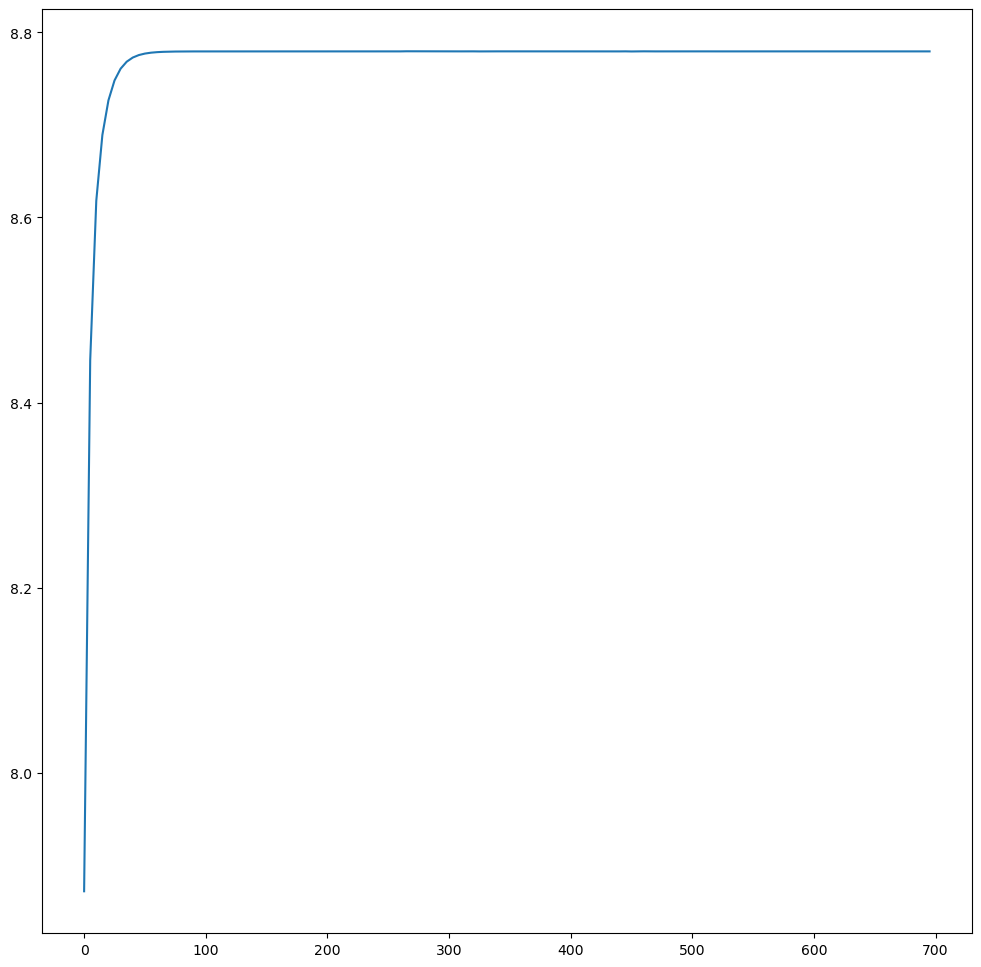

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(testResults["Epochs"], testResults["XY_dist"])
plt.show()

In [15]:
nAnchors = 24
batchSize = 8
learningRate = 0.00003
gamma = 0.5
numEpochs = 1000

trainDataset = AnchorDataSet(file= f"./ShopFacade/traindata_with_features_and_anchors{nAnchors}.pkl")
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True, num_workers=0)

testDataset = AnchorDataSet(file= f"./ShopFacade/testdata_with_features_and_anchors{nAnchors}.pkl")
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, shuffle=True, num_workers=0)

myNet = anchorNet(nAnchors=nAnchors).to(device)
dofLoss = nn.MSELoss().to(device)
crossEntropy = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(myNet.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=gamma)

myAnchors = torch.from_numpy(np.loadtxt(f"./ShopFacade/anchors{nAnchors}.txt")).to(device)

epochs = []
testXY = []
testZ = []
testRot = []
trainLoss = []
trainCELoss = []

for epoch in range(numEpochs):
    epochLoss = 0
    trainDists = []
    zTrain = []
    dofTrain = []

    for i, data in enumerate(trainDataloader):

        myNet.train()

        optimizer.zero_grad()
        
        myFeats = data["Features"]
        myFeats = myFeats.to(device)

        myAnchorDistsGt = data["anchorDists"]
        myAnchorDistsGt = myAnchorDistsGt.to(device)

        myDofGt = data["dofs"]
        myDofGt = myDofGt.to(device)

        myXyGt = data["xy"]
        myXyGt = myXyGt.to(device)

        classify, regress, dof_regress = myNet.forward(myFeats)
        loss, cEntLoss = custom_loss(classify, regress, dof_regress, anchorDistsGt=myAnchorDistsGt, dofGt=myDofGt, dofLoss=dofLoss, crossEntropy=crossEntropy, factors=[1,0,1])
        loss.backward()
        
        optimizer.step()
        dLoss = loss.data.item()
        epochLoss += dLoss
        
        with torch.no_grad():
            bestAnchor = torch.argmax(classify, axis=1).to(device)

            dist = 0
            dofDist = 0

            for j in range(bestAnchor.size()[0]):
                dist += torch.linalg.norm(torch.abs((myAnchors[bestAnchor[j], :] - regress.reshape(-1,nAnchors,2)[j,bestAnchor[j], :]) - (myXyGt)[j]))
                dofDist += np.mean(Rotation.from_quat(dof_regress[j,1:].cpu().detach().numpy()).as_euler("xyz", degrees=True) - Rotation.from_quat(myDofGt[j,1:].cpu().detach().numpy()).as_euler("xyz",degrees=True))

            trainDists.append(dist.data.item() / bestAnchor.size()[0])
            zTrain.append(torch.mean(dof_regress[:,0] - myDofGt[:,0]).data.item())
            dofTrain.append(dofDist/bestAnchor.size()[0])

            trainLoss.append(dLoss)
            trainCELoss.append(cEntLoss)


            
    if (epoch)%100==0:

        print(f"Loss in epoch {epoch}: ", epochLoss)
        print("Training Dist: ", np.mean(trainDists),"m")
        print("z dist: ", np.mean(zTrain), "m, dof dist: ", np.mean(dofTrain), "°")

    # ===========TESTING=============

    if epoch%5 == 0:
        
        epochs.append(epoch)    
        testDists = []
        zTest = []
        dofTest = []

        for idx, data in enumerate(testDataloader):

            myNet.eval()

            myFeats = data["Features"]
            myFeats = myFeats.to(device)

            myAnchorDistsGt = data["anchorDists"]
            myAnchorDistsGt = myAnchorDistsGt.to(device)

            myDofGt = data["dofs"]
            myDofGt = myDofGt.to(device)

            myXyGt = data["xy"]
            myXyGt = myXyGt.to(device)

            classify, regress, dof_regress = myNet.forward(myFeats)
            
            bestAnchor = torch.argmax(classify, axis=1).to(device)

            dist = 0
            dofDist = 0

            for j in range(bestAnchor.size()[0]):
                dist += torch.linalg.norm(torch.abs((myAnchors[bestAnchor[j], :] - regress.reshape(-1,nAnchors,2)[j,bestAnchor[j], :]) - (myXyGt)[j]))
                dofDist += np.mean(Rotation.from_quat(dof_regress[j,1:].cpu().detach().numpy()).as_euler("xyz", degrees=True) - Rotation.from_quat(myDofGt[j,1:].cpu().detach().numpy()).as_euler("xyz",degrees=True))

            testDists.append(dist.data.item() / bestAnchor.size()[0])
            zTest.append(torch.mean(dof_regress[:,0] - myDofGt[:,0]).data.item())
            dofTest.append(dofDist/bestAnchor.size()[0])
        
        testXY.append(np.mean(testDists))
        testZ.append(np.mean(zTest))
        testRot.append(np.mean(dofTest))

testResults = pd.DataFrame(data={"Epochs":epochs, "XY_dist":testXY, "Z_Dist":testZ,"angle_error":testRot})
testResults.to_csv(f"./ShopFacade/testResults_with_{nAnchors}anchors_shuffle.csv")

lossDf = pd.DataFrame(data={"TotalLoss": trainLoss, "CrossEntropyLoss":trainCELoss})
lossDf.to_csv(f"./ShopFacade/trainLoss_with_{nAnchors}anchors_shuffle.csv")

Loss in epoch 0:  95295.0266785329
Training Dist:  10.714538934893989 m
z dist:  -1.8769186391724424 m, dof dist:  -13.60679085146643 °
Cross Entropy Loss of classifier:  3.185476239277911
Cross Entropy Loss of classifier:  3.1723332255017938
Cross Entropy Loss of classifier:  3.151226296269733
Cross Entropy Loss of classifier:  3.179777764070565
Cross Entropy Loss of classifier:  3.079096320860188
Cross Entropy Loss of classifier:  3.214316118456218
Cross Entropy Loss of classifier:  3.2015835840226767
Loss in epoch 100:  93948.07156417929
Training Dist:  10.383075160503134 m
z dist:  1.400715441364928e-05 m, dof dist:  99.87287354093854 °
Cross Entropy Loss of classifier:  3.138454270922249
Cross Entropy Loss of classifier:  3.0353535670807945
Cross Entropy Loss of classifier:  3.2069848403182317
Cross Entropy Loss of classifier:  3.2173459816399097
Cross Entropy Loss of classifier:  3.217996475820419
Cross Entropy Loss of classifier:  3.223309922712292
Loss in epoch 200:  93863.8852

In [ ]:
nAnchors = 25

trainDataset = AnchorDataSet(file= f"./kaggle-data/train/sacre_coeur/traindata_with_features_and_anchors25.pkl")
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=16, shuffle=False, num_workers=0)

testDataset = AnchorDataSet(file= f"./kaggle-data/train/sacre_coeur/testdata_with_features_and_anchors25.pkl")
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=16, shuffle=False, num_workers=0)

myNet = anchorNet(nAnchors=nAnchors).to(device)
dofLoss = nn.MSELoss().to(device)
crossEntropy = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(myNet.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.5)

myAnchors = torch.from_numpy(np.loadtxt(f"./kaggle-data/train/sacre_coeur/anchors{nAnchors}.txt")).to(device)

epochs = []
testXY = []
testZ = []
testRot = []


for epoch in range(numEpochs):
    epochLoss = 0
    trainDists = []
    zTrain = []
    dofTrain = []

    for i, data in enumerate(trainDataloader):

        myNet.train()

        optimizer.zero_grad()
        
        myFeats = data["Features"]
        myFeats = myFeats.to(device)

        myAnchorDistsGt = data["anchorDists"]
        myAnchorDistsGt = myAnchorDistsGt.to(device)

        myDofGt = data["dofs"]
        myDofGt = myDofGt.to(device)

        myXyGt = data["xy"]
        myXyGt = myXyGt.to(device)

        classify, regress, dof_regress = myNet.forward(myFeats)
        loss, cEntLoss = custom_loss(classify, regress, dof_regress, anchorDistsGt=myAnchorDistsGt, dofGt=myDofGt, dofLoss=dofLoss, crossEntropy=crossEntropy, factors=[2.4,1.,0.5])
        loss.backward()
        
        optimizer.step()
        epochLoss += loss.data.item()
        
        with torch.no_grad():
            bestAnchor = torch.argmax(classify, axis=1).to(device)

            dist = 0
            dofDist = 0

            for j in range(bestAnchor.size()[0]):
                dist += torch.linalg.norm(torch.abs((myAnchors[bestAnchor[j], :] - regress.reshape(-1,nAnchors,2)[j,bestAnchor[j], :]) - (myXyGt)[j]))
                dofDist += np.mean(Rotation.from_quat(dof_regress[j,1:].cpu().detach().numpy()).as_euler("xyz", degrees=True) - Rotation.from_quat(myDofGt[j,1:].cpu().detach().numpy()).as_euler("xyz",degrees=True))

            trainDists.append(dist.data.item() / bestAnchor.size()[0])
            zTrain.append(torch.mean(dof_regress[:,0] - myDofGt[:,0]).data.item())
            dofTrain.append(dofDist/bestAnchor.size()[0])

            
    if (epoch+1)%100==0:

        print(f"Loss in epoch {epoch}: ", epochLoss)
        print("Training Dist: ", np.mean(trainDists),"m")
        print("z dist: ", np.mean(zTrain), "m, dof dist: ", np.mean(dofTrain), "°")

    # ===========TESTING=============

    if epoch%5 == 0:
        
        epochs.append(epoch)    
        testDists = []
        zTest = []
        dofTest = []

        for idx, data in enumerate(testDataloader):

            myNet.eval()

            myFeats = data["Features"]
            myFeats = myFeats.to(device)

            myAnchorDistsGt = data["anchorDists"]
            myAnchorDistsGt = myAnchorDistsGt.to(device)

            myDofGt = data["dofs"]
            myDofGt = myDofGt.to(device)

            myXyGt = data["xy"]
            myXyGt = myXyGt.to(device)

            classify, regress, dof_regress = myNet.forward(myFeats)
            
            bestAnchor = torch.argmax(classify, axis=1).to(device)

            dist = 0
            dofDist = 0

            for j in range(bestAnchor.size()[0]):
                dist += torch.linalg.norm(torch.abs((myAnchors[bestAnchor[j], :] - regress.reshape(-1,nAnchors,2)[j,bestAnchor[j], :]) - (myXyGt)[j]))
                dofDist += np.mean(Rotation.from_quat(dof_regress[j,1:].cpu().detach().numpy()).as_euler("xyz", degrees=True) - Rotation.from_quat(myDofGt[j,1:].cpu().detach().numpy()).as_euler("xyz",degrees=True))

            testDists.append(dist.data.item() / bestAnchor.size()[0])
            zTest.append(torch.mean(dof_regress[:,0] - myDofGt[:,0]).data.item())
            dofTest.append(dofDist/bestAnchor.size()[0])
        
        testXY.append(np.mean(testDists))
        testZ.append(np.mean(zTest))
        testRot.append(np.mean(dofTest))

testResults = pd.DataFrame(data={"Epochs":epochs, "XY_dist":testXY, "Z_Dist":testZ,"angle_error":testRot})
testResults.to_csv(f"./kaggle-data/train/sacre_coeur/testResults_with_{nAnchors}anchors.csv")

Cross Entropy Loss of classifier:  3.2128696871881663
Cross Entropy Loss of classifier:  3.148889985730453
Cross Entropy Loss of classifier:  3.229390583062703
Cross Entropy Loss of classifier:  3.07705169544591
Loss in epoch 99:  20241.01608518687
Training Dist:  21.48697679888505 m
z dist:  -0.008488098899471108 m, dof dist:  0.1255253969415046 °
Cross Entropy Loss of classifier:  3.2796124143266843
Loss in epoch 199:  20240.493792429923
Training Dist:  21.486572124500675 m
z dist:  -0.0002436956618416808 m, dof dist:  0.12326931484303483 °
Cross Entropy Loss of classifier:  3.1012448990590182
Cross Entropy Loss of classifier:  3.160700464366539
Cross Entropy Loss of classifier:  3.222307846374841
Loss in epoch 299:  20240.3900735086
Training Dist:  21.486474148498047 m
z dist:  -0.00022798967155179817 m, dof dist:  0.12412885221843856 °
Cross Entropy Loss of classifier:  3.2834053501119493
Cross Entropy Loss of classifier:  3.2223775134386003
Cross Entropy Loss of classifier:  3.222